# Predict purchasing probability for financial product - Exploratory Data Analysis
#### Andreas Forster

### Introduction
-  Push calculations down to SAP HANA. 
-  Leverage the in-memory performance directly out of Python without data extraction.

### Documentation
-  SAP HANA Python Client API for Machine Learning Algorithms:   
   https://help.sap.com/doc/0172e3957b5946da85d3fde85ee8f33d/latest/en-US/html/hana_ml.html
-  SAP HANA Automated Predictive Library (APL):
   https://help.sap.com/viewer/cb31bd99d09747089754a0ba75067ed2/latest/en-US/5db34eae84ed44e49ec1f0f78dfb52a1.html
-  Dataset: https://archive.ics.uci.edu/ml/datasets/bank+marketing

### Create a HANA DataFrame, which points to the training data that remains in SAP HANA

In [1]:
# Obtain logon details from the central Connection Management of SAP Data Intelligence
import hana_ml.dataframe as dataframe

# Instantiate connection object
from notebook_hana_connector.notebook_hana_connector import NotebookConnectionContext
conn = NotebookConnectionContext(connectionId='HANADB')

# Create the HANA dataframe in the structure of the specified table / view
df_pushdown = conn.table("BANKMARKETING", schema="TAXX")

### Peek at the data and retrieve a small number of rows

In [2]:
df_pushdown.head(5).collect()

,CLIENT_ID,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,POUTCOME,Y
0,34.0,59.0,blue-collar,married,secondary,no,0.0,yes,no,unknown,5.0,may,unknown,no
1,37.0,25.0,blue-collar,married,secondary,no,-7.0,yes,no,unknown,5.0,may,unknown,no
2,51.0,54.0,blue-collar,married,secondary,no,1291.0,yes,no,unknown,5.0,may,unknown,no
3,101.0,44.0,blue-collar,married,secondary,no,-674.0,yes,no,unknown,5.0,may,unknown,no
4,106.0,44.0,blue-collar,married,secondary,no,54.0,yes,no,unknown,5.0,may,unknown,no


### Get row count

In [3]:
df_pushdown.count()

45211

### Get data types

In [4]:
df_pushdown.dtypes()

[('CLIENT_ID', 'DOUBLE', 15),
 ('AGE', 'DOUBLE', 15),
 ('JOB', 'NVARCHAR', 100),
 ('MARITAL', 'NVARCHAR', 100),
 ('EDUCATION', 'NVARCHAR', 100),
 ('DEFAULT', 'NVARCHAR', 100),
 ('BALANCE', 'DOUBLE', 15),
 ('HOUSING', 'NVARCHAR', 100),
 ('LOAN', 'NVARCHAR', 100),
 ('CONTACT', 'NVARCHAR', 100),
 ('DAY', 'DOUBLE', 15),
 ('MONTH', 'NVARCHAR', 100),
 ('POUTCOME', 'NVARCHAR', 100),
 ('Y', 'NVARCHAR', 100)]

### Get column statistics

In [5]:
df_pushdown.describe().collect()

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,CLIENT_ID,45211,45211,0,22606.000000,13051.435847,1.0,45211.0,22606.0,11303.5,11303.0,22606.0,22606.0,33908.5,33909.0
1,AGE,45211,77,0,40.936210,10.618762,18.0,95.0,39.0,33.0,33.0,39.0,39.0,48.0,48.0
2,BALANCE,45211,7168,0,1362.272058,3044.765829,-8019.0,102127.0,448.0,72.0,72.0,448.0,448.0,1428.0,1428.0
3,DAY,45211,31,0,15.806419,8.322476,1.0,31.0,16.0,8.0,8.0,16.0,16.0,21.0,21.0
4,JOB,45211,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,MARITAL,45211,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,EDUCATION,45211,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,DEFAULT,45211,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,HOUSING,45211,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,LOAN,45211,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Display the underlying SELECT statement for transparency / verification / modification
#df_pushdown.describe().select_statement

### Category frequency for Target variable
The Automated Classification carries out a binary classification. Hence the target variable must contain exactly two different values. 

In [7]:
top_n = 5 
variable_name = 'Y'

# Get Top N categories
df_pushdown_col_frequency = df_pushdown.agg([('count', variable_name, 'COUNT')],  group_by=variable_name)
df_col_frequency = df_pushdown_col_frequency.sort("COUNT", desc=True).head(top_n).collect()
print(df_col_frequency)

     Y  COUNT
0   no  39922
1  yes   5289


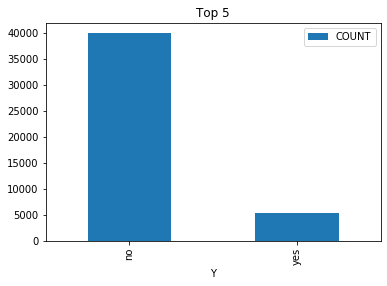

In [8]:
%matplotlib inline 
df_col_frequency.plot.bar(x='Y', y="COUNT", title="Top " + str(top_n));

### Close connection

In [ ]:
conn.close()